##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adversarial example using FGSM

This tutorial creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

## What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. One of the most famous examples of an adversarial image shown below is taken from the aforementioned paper.

![Adversarial Example](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/adversarial_example.png?raw=1)

Here, starting with the image of a panda, the attacker adds small perturbations (distortions) to the original image, which results in the model labelling this image as a gibbon, with high confidence. The process of adding these perturbations is explained below.

## Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool a pretrained model. In this tutorial, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).

In [ ]:
import json

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Let's load the pretrained MobileNetV2 model.

In [ ]:
# load model
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

14536120/14536120 [==============================] - 2s 0us/step


You can check all the classes in the ImageNet dataset - there are 1000 in total.

In [ ]:
fpath = tf.keras.utils.get_file("imagenet_class_index.json", "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json")
with open(fpath) as f:
  raw_imagenet_classes = json.load(f)

for idx, class_info in raw_imagenet_classes.items():
  print('{}: {}'.format(idx, class_info[1]))

0: tench
1: goldfish
2: great_white_shark
3: tiger_shark
4: hammerhead
5: electric_ray
6: stingray
7: cock
8: hen
9: ostrich
10: brambling
11: goldfinch
12: house_finch
13: junco
14: indigo_bunting
15: robin
16: bulbul
17: jay
18: magpie
19: chickadee
20: water_ouzel
21: kite
22: bald_eagle
23: vulture
24: great_grey_owl
25: European_fire_salamander
26: common_newt
27: eft
28: spotted_salamander
29: axolotl
30: bullfrog
31: tree_frog
32: tailed_frog
33: loggerhead
34: leatherback_turtle
35: mud_turtle
36: terrapin
37: box_turtle
38: banded_gecko
39: common_iguana
40: American_chameleon
41: whiptail
42: agama
43: frilled_lizard
44: alligator_lizard
45: Gila_monster
46: green_lizard
47: African_chameleon
48: Komodo_dragon
49: African_crocodile
50: American_alligator
51: triceratops
52: thunder_snake
53: ringneck_snake
54: hognose_snake
55: green_snake
56: king_snake
57: garter_snake
58: water_snake
59: vine_snake
60: night_snake
61: boa_constrictor
62: rock_python
63: Indian_cobra
64: gr

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224)) # the model expects images that are 224 x 224 pixels
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]

# helper function to display an image
def display_image(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5) # change [-1, 1] to [0,1]
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) by Mirko [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [ ]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)

# TODO - get the model predictions for the image
image_probs = None

Let's have a look at the image.

35363/35363 [==============================] - 0s 0us/step


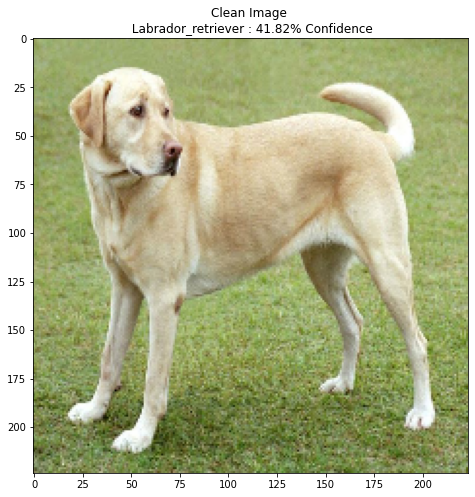

In [ ]:
display_image(image, 'Clean Image')

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [ ]:
# TODO - the CategoricalCrossEntropy is a suitable loss function in this scenario
loss_object = None

def create_perturbations(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)

  # TODO - get the sign of the gradients to create the perturbation
  signed_grad = None
  
  return signed_grad

The resulting perturbations can also be visualised.

In [ ]:
# get the true label of the image
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

# TODO - generate the perturbations using the function you've created
perturbations = None
plt.imshow(perturbations[0] * 0.5 + 0.5);  # change [-1,1] to [0,1]

Let's try this out for different values of epsilon and observe the resultant image.

What happens when the value of epsilon is increased? Is there any trade-off?

In [ ]:
# TODO - play around with these values
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Clean Image') for eps in epsilons]

for i, eps in enumerate(epsilons):
  # TODO - remember the expression for FGSM and put everything together
  adv_x = None

  adv_x = tf.clip_by_value(adv_x, -1, 1) # we want to make sure the image is still valid

  display_image(adv_x, descriptions[i])

You can try using other images to generate adversarial examples.

But if you use an image of something that is not a labrador retriever, don't forget to check the index of that class and change it accordingly.